In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

/home/dmitry/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [83]:
# 1 aug 2014 - 31 oct 2015, 153 1 jan 2015
trans = pd.read_csv('data/transactions.csv')
customers_gender = pd.read_csv('data/customers_gender_train.csv')
mcc_desc = pd.read_csv('data/tr_mcc_codes.csv', delimiter=';')
trans['day'] = trans['tr_datetime'].str.split().str[0].astype(int)
# amount
trans = trans[trans.amount < 0].copy()
# trans = trans.where((trans.amount/2.245915772).round(2)!=-3e7, 0) # that strange guy
# print trans[trans.customer_id==48281795]
# trans['amount'] = (trans['amount']/2.245915772).round(2)

train = pd.DataFrame(columns=trans.mcc_code.unique(), index=trans.day.unique())
train = train.unstack().reset_index().dropna(axis=1)
train.columns = ['mcc_code', 'day']
train = pd.merge(train, trans.groupby(['day', 'mcc_code'])[['amount']].sum().reset_index(), how='left').fillna(0)

# def f(group):
#     group.amount.where(group.amount > 0.99 * group.amount.min(), 0, inplace=True)
#     return group
# train = train.groupby('mcc_code').apply(f)

test = pd.DataFrame(columns=trans.mcc_code.unique(), index=range(457, 487))
test = test.unstack().reset_index().dropna(axis=1)
test.columns = ['mcc_code', 'day']

for table in [train, test]:
#     table['dayy'] = np.where(table['day']>=153, table['day'] - 152, table['day'] - 152 + 365)
    table['year'] = np.where(table['day'] < 365, 0, 1)
    table['dayw'] = (table['day'] - 3) % 7
    monthes = np.array([0, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]).cumsum()# in month
    table['daym'] = table['day'] + 1
    table['month'] = 0
    for i in range(len(monthes)-1):
        cond = (table.day + 1 > monthes[i]) & (table.day + 1 <= monthes[i+1]) & (table.month == 0)
        table.ix[cond, 'month'] = (i + 7) % 12 + 1
        table.ix[cond, 'daym'] = table.daym - monthes[i]
        
    holidays = [[0,11,3], [0,11,4],
                [1,1,1],[1,1,2],[1,1,3],[1,1,4],[1,1,5],[1,1,6],[1,1,7],[1,1,8],[1,1,9],[1,1,10],[1,1,11],
                [1,2,23], [1,3,9],
                [1,5,1],[1,5,2],[1,5,3],[1,5,4],[1,5,9],[1,5,10],[1,5,11],
                [1,6,12],
                [1,11,4]]
    for h in holidays:
        table.ix[(table.year==h[0]) & (table.month==h[1]) & (table.daym==h[2]), 'dayw'] = 6

train = train.sort_values('day')
print train.head()
print train.shape
print test.shape

X = train.drop('amount', axis=1)
Y = train['amount']
Y = np.log(-Y + 500)
del trans
# del train

alpha = 1/15
n = int((1 - alpha) * X.shape[0])
X_train, X_test, Y_train, y_test = X[:n], X[n:], Y[:n], Y[n:]

       mcc_code  day       amount  year  dayw  daym  month
0          4814    0 -11098744.26     0     4     1      8
51184      4215    0    -26271.82     0     4     1      8
18280      7298    0   -100280.14     0     4     1      8
82717      1731    0         0.00     0     4     1      8
50727      7932    0         0.00     0     4     1      8
(84088, 7)
(5520, 6)


In [73]:
def xgb_train_test(params, n_est):
    xgb_train = xgb.DMatrix(data=X_train, label=Y_train)
    xgb_test = xgb.DMatrix(data=X_test, label=y_test)
    evals = [(xgb_train, 'train'), (xgb_test, 'test')]
    model = xgb.train(params, xgb_train, n_est, evals, verbose_eval=50, early_stopping_rounds=100)
    print model.best_iteration, model.best_score
    return model.best_iteration

def xgb_train_fit(params, n_est):
    xgb_train = xgb.DMatrix(data=X, label=Y)
    model = xgb.train(params, xgb_train, n_est)
    return model.predict(xgb.DMatrix(test))

In [63]:
# 1.773575 baseline
# 1.574618 dayy, dayw
# 1.574071         1.70277 year, month, dayw, daym, rate=0.1
# 1.564839       1.697663 year, month, dayw, daym, rate=0.01
# 1.573185 1.51007 1.670133 year, month, dayw, daym, holiday, rate=0.1
#6 1.564023 year, month, dayw, daym, holiday, rate=0.03
# 1.609381       1.700743 0.99 max amount cut
# 1.58443 1.52236 del 30 million transactions

params = {
'nthread': 24,
'booster': 'gbtree',
'objective': 'reg:linear',
'eval_metric': 'rmse',
'learning_rate': 0.1,
'n_estimators': 400,
'max_depth': 5,
'min_child_weight': 1,
'gamma': 0,
'subsample': 0.6,
'colsample_bytree': 0.8,
'silent': 0,
}

In [84]:
n_est = xgb_train_test(params, n_est=10000)

[0]	train-rmse:9.52214	test-rmse:9.78085
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[50]	train-rmse:2.27614	test-rmse:2.2588
[100]	train-rmse:1.95646	test-rmse:1.96038
[150]	train-rmse:1.73403	test-rmse:1.75697
[200]	train-rmse:1.63585	test-rmse:1.67171
[250]	train-rmse:1.59867	test-rmse:1.63803
[300]	train-rmse:1.56376	test-rmse:1.60713
[350]	train-rmse:1.54592	test-rmse:1.59173
[400]	train-rmse:1.53281	test-rmse:1.58419
[450]	train-rmse:1.52268	test-rmse:1.57994
[500]	train-rmse:1.51443	test-rmse:1.57407
[550]	train-rmse:1.50863	test-rmse:1.57845
[600]	train-rmse:1.50225	test-rmse:1.57753
Stopping. Best iteration:
[538]	train-rmse:1.51007	test-rmse:1.57319

538 1.573185


In [85]:
# train fit write
res = test.copy()
res['volume'] = np.e ** xgb_train_fit(params, n_est=300) - 500
res.ix[res.volume < 0, 'volume'] = 0
res[['mcc_code', 'day', 'volume']].to_csv('b.csv', index=False)
print res.head()

   mcc_code  day  year  dayw  daym  month     volume
0      4814  457     1     6     1     11  5772191.0
1      4814  458     1     0     2     11  8633823.0
2      4814  459     1     1     3     11  8611931.0
3      4814  460     1     6     4     11  5476797.5
4      4814  461     1     3     5     11  9302597.0


4814


/home/dmitry/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Liberation Serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


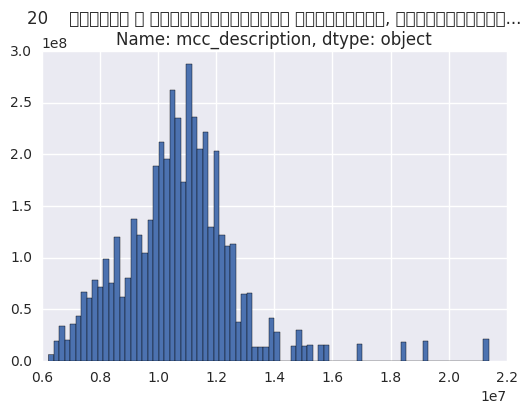

In [3]:
for mcc in train.mcc_code.unique():
    print mcc
    i = train.mcc_code==mcc
    y = -train[i]['amount']
#     plt.plot(-train.loc[i][['day','amount']].values)
    plt.hist(y, 80, weights=y)
    plt.title(mcc_desc[mcc_desc.mcc_code==mcc]['mcc_description'].to_string())
    plt.savefig('fig/'+str(mcc)+'.png')
    plt.clf()
# a = train.groupby('day')['amount'].sum().reset_index()
# plt.hist(a.amount, bins=100)